In [28]:
%matplotlib inline
import os 
import numpy as np
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon
import statsmodels.api as sm
pd.options.display.max_columns = 99
import statsmodels.formula.api as smf
import math 
import scipy.stats as ss
plt.rcParams['font.family'] = 'Myriad Pro'
sns.set_style('white')

clinical_dir  = '/Users/kanaan/SCR/Dataframes_20150820/DF_clinical/'
datadir = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Presentations/2016_06_ESSTS_QSM'

measures = [ 'Caud', 'Puta', 'Pall', 'Thal', 'Accu', 'Amyg', 'Hipp', 'RN', 'SN','STN', 
             'BrainStem', 'BasalGanglia', 'Insula', 'Cingulum',
           ]

drop_c =  []
drop_p = []# ['NL2P', 'STDP', 'HSPP', 'CB4P', 'SA5U']  # Based on quality control of MP2RAGE_UNI 


In [29]:
def plot(df1,df2,measure):
    palette = sns.xkcd_palette([ "red", 'blue'])
    data = [df1[measure], df2[measure]]
    sns.violinplot(data=data, palette= palette)
    sns.stripplot(data=data,palette= palette, jitter=1)

    
def detect_outliers(df, measure):
    mu = np.mean(df[measure])
    sd = np.std(df[measure])
    thresh = 3
    upper = mu +thresh*sd
    lower = mu -thresh*sd
    outliers = []
    for subject in df.index:
        i = df.loc[subject][measure]
        if i > upper or i < lower:
            outliers.append(subject)
            df.ix[subject, measure] = np.nan
            print outliers
            print 'OUTLIER: %s %s= %s, Limits= (%s,%s)'%(subject, measure, i, lower, upper)
    
    return outliers

def plot_partial_correlation(data, x, y,  regressors = None, color = None, annotate = None, fig_name = None, 
                             dpi = 100, labels = True, jitter = None):
    
    regressors_columns = [data[regressor] for regressor in regressors]
    df_reg = pd.concat(regressors_columns, axis = 1).dropna(axis=0) 
    df = pd.concat([df_reg, data[x], data[y]], axis=1).dropna()
    
    # inititlize grid and plot regression and margins 
    grid = sns.JointGrid(x, y, data=df)#, size=size, ratio=ratio, space=space, #xlim=xlim, ylim=ylim), xlim=xlim, ylim=ylim
    grid.plot_marginals(sns.distplot, color = color, hist=False, kde = True, rug = 0, kde_kws={'shade':True})  
    
    grid.plot_joint(sns.regplot, color = color, x_partial = df[regressors], y_jitter = jitter)
    if labels:
        grid.set_axis_labels(x, y, fontsize= 15, weight='bold', color='blue', labelpad=10)
    else:
        grid.set_axis_labels(None,None)
        
    ## calculate regression parameters 
    
    formula = [ '%s ~ %s'%(y,x) + ' + %s'%regressor for regressor in regressors][0]
    model   = smf.ols(formula=formula, data= df)
    result = model.fit() 
    p_val  = np.round(result.pvalues[1], 3)
    pcor   = math.copysign(np.round(np.sqrt(result.rsquared), 3) , result.params[1])
    
    if annotate:
        plt.annotate('R=%s, P=%s' %(pcor, p_val), xy = annotate, fontsize = 13,  color='r')
                      
    if fig_name:
        plt.savefig(os.path.join(save_fig_dir, fig_name), dpi = dpi, bbox_inches='tight', transparent = True)

df1 = pd.read_csv(os.path.join(datadir, 'controls_a_DICOM.csv'), index_col = 0)
df2 = pd.read_csv(os.path.join(datadir, 'controls_a.csv'), index_col = 0)

In [30]:
def make_ttest():
    df1 = pd.read_csv(os.path.join(datadir, 'controls_a_DICOM.csv'), index_col = 0)# * 100
    df2 = pd.read_csv(os.path.join(datadir, 'controls_a.csv'), index_col = 0)# * 100
    
    df = pd.DataFrame(index= ['Controls', 'Patients', 'Z', 'p_val',], columns=measures)
    for measure in measures:
        #drop_c = detect_outliers(df1, measure)
        #drop_p = detect_outliers(df2, measure)
        t_val, p_val = mannwhitneyu(df1[measure], df2[measure].drop(drop_p, axis = 0))
        #t_val, p_val = ttest_ind(df1[measure], df2[measure].drop(drop_p, axis = 0))
        x = 100
        df.ix['Controls'][measure] = '%s±%s'%(x*np.round(np.mean(df1[measure]),4), 
                                              x*np.round(np.std(df1[measure]),4))     
        df.ix['Patients'][measure] = '%s±%s'%(x*np.round(np.mean(df2[measure].drop(drop_p, axis = 0)),4), 
                                              x*np.round(np.std(df2[measure].drop(drop_p, axis = 0)),4))   
        df.ix['Z'][measure] = np.round(t_val,2)        
        df.ix['p_val'][measure] = np.round(p_val,5)
        
        if p_val < 0.05:
            print measure, 'p =', np.round(p_val,3)
        
    return df.T
x = make_ttest()
x.sort(columns='p_val')

,Controls,Patients,Z,p_val
Caud,2.39±1.6,1.8±1.23,185,0.09239
Insula,-2.33±1.54,-2.96±1.03,190,0.11336
STN,0.03±4.26,1.43±3.33,194,0.13244
RN,6.55±4.72,5.5±4.06,200,0.165
BasalGanglia,2.32±1.34,1.98±1.02,204,0.18937
Hipp,-1.15±1.51,-1.44±0.9,204,0.18937
SN,10.33±3.88,11.23±2.43,205,0.19579
Thal,-3.29±1.71,-3.24±1.21,208,0.21584
Cingulum,-2.05±1.45,-2.56±0.82,210,0.22984
Accu,-1.59±2.27,-2.2±1.93,214,0.2593


In [31]:
pd.DataFrame(x.p_val).sort(columns='p_val')

,p_val
Caud,0.09239
Insula,0.11336
STN,0.13244
RN,0.165
BasalGanglia,0.18937
Hipp,0.18937
SN,0.19579
Thal,0.21584
Cingulum,0.22984
Accu,0.2593


In [32]:
def make_fdr(df):
    fdr = pd.DataFrame()
    for i in df.index:
        for c in df.columns:
            fdr.ix['%s_%s'%(i,c),'p'] = df.loc[i][c]
    fdr = fdr.dropna()
    fdr = fdr.sort('p')
    
    n_comparisons = len(fdr.index)
    for i, corr in enumerate(fdr.index):
        fdr.ix[corr, 'FDR_threshold'] = np.round((0.05 * (i + 1.) / n_comparisons), 3)
        
    return fdr.reindex()

make_fdr(pd.DataFrame(x.p_val))

,p,FDR_threshold
Caud_p_val,0.09239,0.004
Insula_p_val,0.11336,0.007
STN_p_val,0.13244,0.011
RN_p_val,0.16500,0.014
Hipp_p_val,0.18937,0.018
BasalGanglia_p_val,0.18937,0.021
SN_p_val,0.19579,0.025
Thal_p_val,0.21584,0.029
Cingulum_p_val,0.22984,0.032
Accu_p_val,0.25930,0.036


In [33]:
controls_a = pd.read_csv(os.path.join(datadir, 'controls_a.csv'), index_col = 0)
patients_a = pd.read_csv(os.path.join(datadir, 'controls_a_DICOM.csv'), index_col = 0)

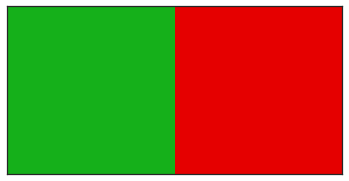

In [34]:
%matplotlib inline
import os 
import numpy as np
from numpy import mean, std
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')

plt.rcParams['font.family'] = 'Myriad Pro'
p = sns.palplot(sns.xkcd_palette(['green', "red"]), size = 3)

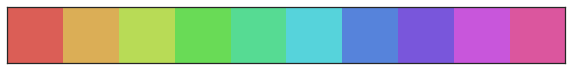

In [35]:
sns.palplot(sns.color_palette("hls",10 ))

[]

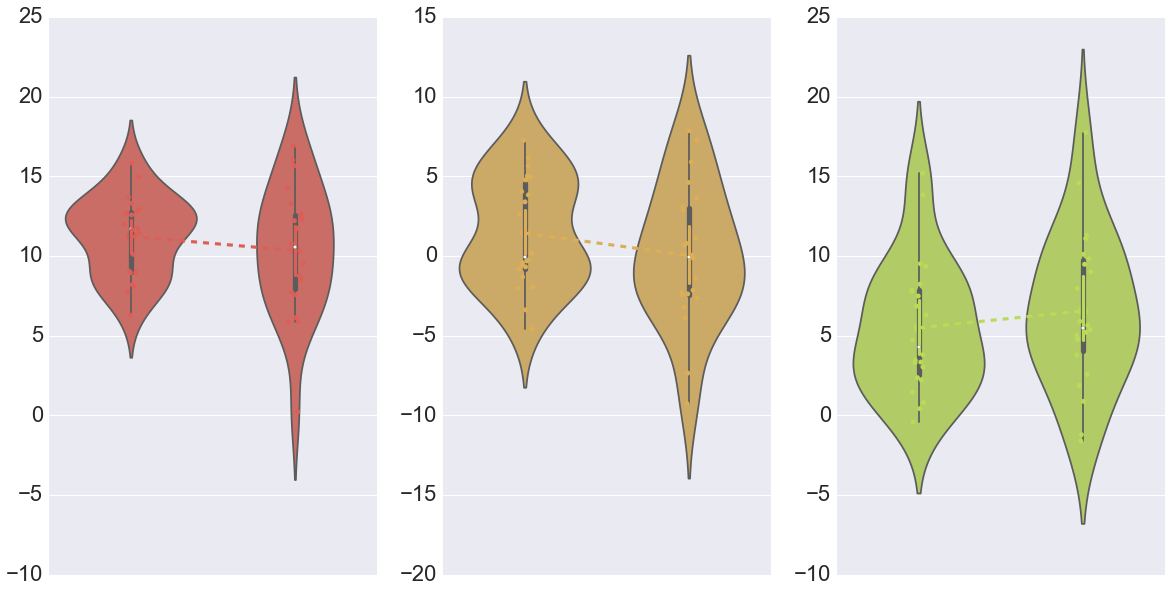

In [36]:
sns.set_style('darkgrid', {"xtick.direction": "in","ytick.direction": "in"})
f, (ax1,ax2,ax3)= plt.subplots(nrows = 1, ncols = 3)
f.set_size_inches([20,10])

jitter = 0.05
drop_p = drop_p #+ ['RA9P']
fontsize = 22

C = controls_a.drop(drop_c, axis = 0) * 100
P = patients_a.drop(drop_p, axis = 0) * 100

measure_1 = 'SN' 
measure_2 = 'STN'
measure_3 = 'RN'

data_1 = [C[measure_1],     P[measure_1]]
data_2 = [C[measure_2],     P[measure_2]]
data_3 = [C[measure_3],     P[measure_3]]

palette = ['#3498db', '#2ecc71', '#e74c3c']
#palette = sns.xkcd_palette(["windows blue", "amber", "greyish", "faded green", "dusty purple"])
palette = sns.color_palette("hls", 10)

sns.violinplot(data = data_1, color = palette[0], ax = ax1)
sns.stripplot(data=data_1, color = palette[0], jitter= jitter, ax = ax1)
sns.pointplot(data=data_1, color = palette[0], linestyles=['--'], markers=['o'], ax =ax1)
ax1.tick_params(axis='y', labelsize=fontsize)

sns.violinplot(data = data_2, color = palette[1],ax = ax2)
sns.stripplot(data=data_2, color = palette[1], jitter= jitter, ax = ax2)
sns.pointplot(data=data_2, color = palette[1], linestyles=['--'], markers=['o'], ax =ax2)
ax2.tick_params(axis='y', labelsize=fontsize)

sns.violinplot(data = data_3, color = palette[2], ax = ax3)
sns.stripplot(data=data_3, color = palette[2], jitter= jitter, ax = ax3)
sns.pointplot(data=data_3, color = palette[2], linestyles=['--'], markers=['o'], ax =ax3)
ax3.tick_params(axis='y', labelsize=fontsize)

#ax1.set_ylim(0, 23)
#ax2.set_ylim(-10, 18) 
#ax3.set_ylim(-10, 30)

ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])

#f.savefig(os.path.join(datadir,'qsm_py_stats','QSM_STATS_1.png'), dpi = 600, bbox_inches='tight', transparent = False)

[]

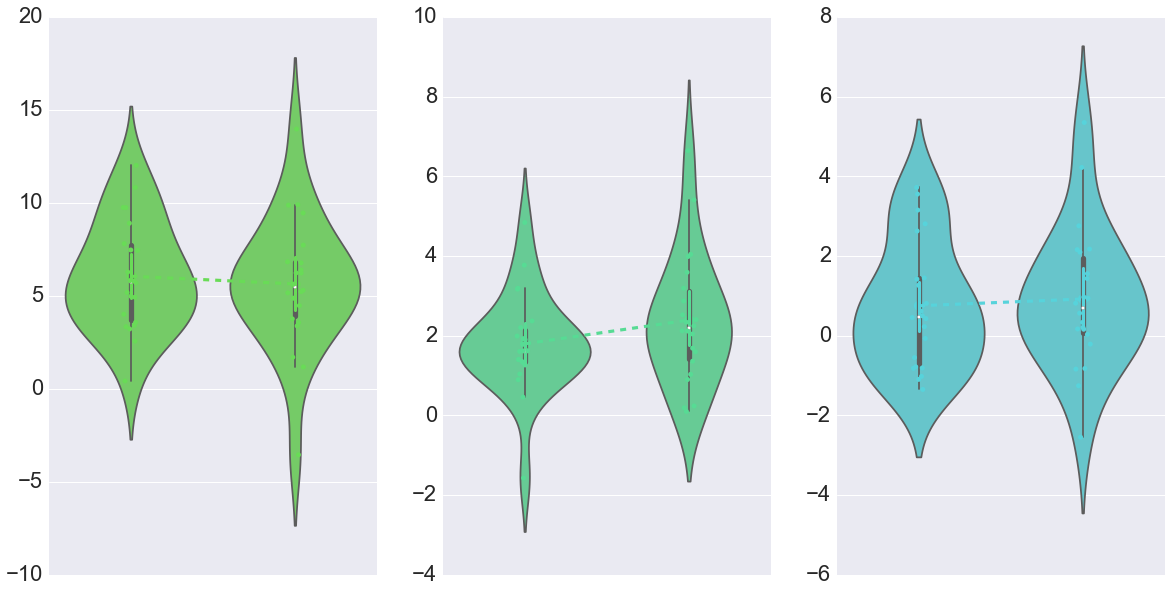

In [37]:
sns.set_style('darkgrid', {"xtick.direction": "in","ytick.direction": "in"})
f, (ax1,ax2,ax3)= plt.subplots(nrows = 1, ncols = 3)
f.set_size_inches([20,10])

jitter = 0.05
drop_p = drop_p #+ ['RA9P']
fontsize = 22

C = controls_a.drop(drop_c, axis = 0) * 100
P = patients_a.drop(drop_p, axis = 0) * 100

measure_1 = 'BrainStem' 
measure_2 = 'Caud'
measure_3 = 'Puta'

data_1 = [C[measure_1],     P[measure_1]]
data_2 = [C[measure_2],     P[measure_2]]
data_3 = [C[measure_3],     P[measure_3]]

palette = ['#3498db', '#2ecc71', '#e74c3c']
#palette = sns.xkcd_palette(["windows blue", "amber", "greyish", "faded green", "dusty purple"])
palette = sns.color_palette("hls", 10)[3:6]

sns.violinplot(data = data_1, color = palette[0], ax = ax1)
sns.stripplot(data=data_1, color = palette[0], jitter= jitter, ax = ax1)
sns.pointplot(data=data_1, color = palette[0], linestyles=['--'], markers=['o'], ax =ax1)
ax1.tick_params(axis='y', labelsize=fontsize)

sns.violinplot(data = data_2, color = palette[1],ax = ax2)
sns.stripplot(data=data_2, color = palette[1], jitter= jitter, ax = ax2)
sns.pointplot(data=data_2, color = palette[1], linestyles=['--'], markers=['o'], ax =ax2)
ax2.tick_params(axis='y', labelsize=fontsize)

sns.violinplot(data = data_3, color = palette[2], ax = ax3)
sns.stripplot(data=data_3, color = palette[2], jitter= jitter, ax = ax3)
sns.pointplot(data=data_3, color = palette[2], linestyles=['--'], markers=['o'], ax =ax3)
ax3.tick_params(axis='y', labelsize=fontsize)

#ax1.set_ylim(-5, 22)
#ax2.set_ylim(-5, 10)
#ax3.set_ylim(-5, 8)


ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])

#f.savefig(os.path.join(datadir,'qsm_py_stats','QSM_STATS_2.png'), dpi = 600, bbox_inches='tight', transparent = False)

[]

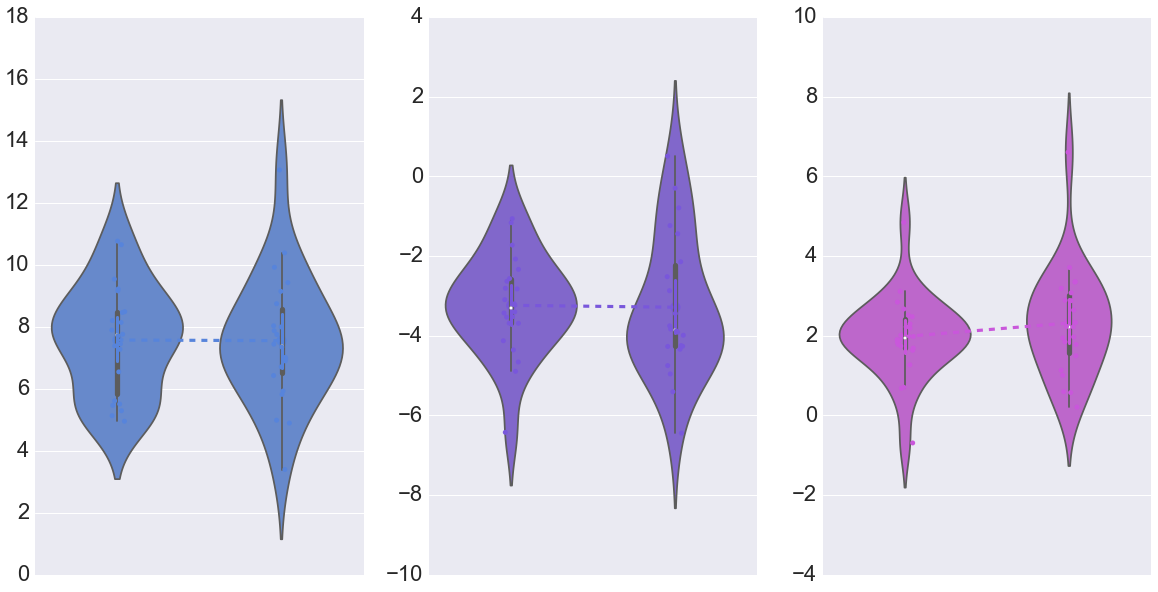

In [38]:
sns.set_style('darkgrid', {"xtick.direction": "in","ytick.direction": "in"})
f, (ax1,ax2,ax3)= plt.subplots(nrows = 1, ncols = 3)
f.set_size_inches([20,10])

jitter = 0.05
drop_p = drop_p #+ ['RA9P']
fontsize = 22

C = controls_a.drop(drop_c, axis = 0) * 100
P = patients_a.drop(drop_p, axis = 0) * 100

measure_1 = 'Pall' 
measure_2 = 'Thal'
measure_3 = 'BasalGanglia'

data_1 = [C[measure_1],     P[measure_1]]
data_2 = [C[measure_2],     P[measure_2]]
data_3 = [C[measure_3],     P[measure_3]]

palette = ['#3498db', '#2ecc71', '#e74c3c']
#palette = sns.xkcd_palette(["windows blue", "amber", "greyish", "faded green", "dusty purple"])
palette = sns.color_palette("hls", 10)[6:9]

sns.violinplot(data = data_1, color = palette[0], ax = ax1)
sns.stripplot(data=data_1, color = palette[0], jitter= jitter, ax = ax1)
sns.pointplot(data=data_1, color = palette[0], linestyles=['--'], markers=['o'], ax =ax1)
ax1.tick_params(axis='y', labelsize=fontsize)

sns.violinplot(data = data_2, color = palette[1],ax = ax2)
sns.stripplot(data=data_2, color = palette[1], jitter= jitter, ax = ax2)
sns.pointplot(data=data_2, color = palette[1], linestyles=['--'], markers=['o'], ax =ax2)
ax2.tick_params(axis='y', labelsize=fontsize)

sns.violinplot(data = data_3, color = palette[2], ax = ax3)
sns.stripplot(data=data_3, color = palette[2], jitter= jitter, ax = ax3)
sns.pointplot(data=data_3, color = palette[2], linestyles=['--'], markers=['o'], ax =ax3)
ax3.tick_params(axis='y', labelsize=fontsize)

#ax1.set_ylim(1, 16)
#ax2.set_ylim(-9, 9)
#ax3.set_ylim(-2, 8)

ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])

#f.savefig(os.path.join(datadir,'qsm_py_stats','QSM_STATS_3.png'), dpi = 600, bbox_inches='tight', transparent = False)